# Consistent Representation Issue

La cohérence de la représentation de la base de données correspond à une étude d'interprétation des données. Il s'agit en effet de déterminer si les objets sont désignés de la même manière dans toute notre base. C'est détecter lorsqu'on a plusieurs représentations pour une même valeur logique. 

exemple : in a feature ‘‘city’’, New York shall not be also represented as NYC or NY. Consistent representation is different from uniqueness, which focuses on ensuring that no duplicate records exist in the dataset

Dans mon cas, je ne repère pas les incohérences dans les valeurs numériques des données mais je me contente bien de m'intéresser à la présence d'abréviations, de raccourcis ou de redondances sémentiques dans ma base. 

Au début on a l'étude de la cohérence colonne par colonne mais peut être que dans un 2e temps on pourrait voir à quels facteurs la colonne est liée pour avoir une idée de regroupement possible car les autres données auront reconnu la valeur logique avec l'exploitation des données. 

Voici les deux approches que je vais essayer d'explorer :
- approche sémentique (basée sur la simple reconnaissance de synonymes)
- détection des abréviations

## Etude de synonymes

### Regroupement par thématique (abandonné)

In [7]:
from nltk.corpus import wordnet as wn
from nltk import download
download('wordnet')
download('omw-1.4')

def get_synsets(word):
    return wn.synsets(word)

def are_similar(word1, word2, threshold=0.8):
    synsets1 = get_synsets(word1)
    synsets2 = get_synsets(word2)
    max_sim = 0
    for s1 in synsets1:
        for s2 in synsets2:
            sim = s1.wup_similarity(s2)
            if sim and sim > max_sim:
                max_sim = sim
    return max_sim >= threshold

# === Traitement progressif ===

seen_groups = []  # liste de listes de mots similaires
input_words = ["sun", "sky", "cloud", "banana", "vehicle", "apple", "mango"]

for word in input_words:
    matched = False
    for group in seen_groups:
        if any(are_similar(word, w) for w in group):
            group.append(word)
            matched = True
            break
    if not matched:
        seen_groups.append([word])

print("Groupes conceptuels détectés :")
for group in seen_groups:
    print(group)


Groupes conceptuels détectés :
['sun']
['sky']
['cloud']
['banana', 'apple', 'mango']
['vehicle']


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/gouineaud/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/gouineaud/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Détection des synonymes 

Le fonctionnement de l'algo de répérage des syonymes sera fondamentalement le même, les différentes méthodes explorer résideront seulement dans la manière d'obtenir les synonymes d'un mot. 
Voici la structure de notre algo
- teste si le mot est un mot "de base" de notre BD, c-a-d qu'on ne prend pas pour synonyme
    - si ce mot ne fait pas partie des mots "de base", on regarde si il fait partie des synonymes trouvés
        - si il fait pas partie des synonymes, alors : 
            - on l'ajoute dans les mots de bases 
            - on ajoute ses synonymes dans les synonymes trouvés => c'est cette phase qu'il faut creuser car c'est compliqué de trouver les synonmyes d'un mot
        - si il fait partie des synonymes trouvés, on compte +1 dans le nombre des éléments qu'il faut changer pour avoir une base cohérente
    - si il fait partie des mots de base, on fait rien

#### API synonymes

amélioration possible :
- plutôt que d'enregistrer mes mots directement dans le dictionnaire, on peut les regrouper par thématique (WordNet)
- faire une recherche http sur ce site : https://crisco4.unicaen.fr/des/synonymes et recup les 3 premiers synonymes utilisés. 

In [10]:
#import
import pandas as pd
import requests

#input
#fichier = "words.csv"
#fichier = "big_words.csv"
fichier = "synonym_rich_dataset.csv"

In [8]:
def synonyme_from_api(word):
    url = f"https://api.datamuse.com/words?rel_syn={word}"
    response = requests.get(url)
    if response.status_code == 200:
        return [item['word'] for item in response.json()]
    return []

def synonym_from_http (word) : 
    synonymes=[]
    ##algo trouver synonyme avec http 
    return synonymes


In [ ]:
# Lire le fichier
df = pd.read_csv(fichier)
print("Jeu de donnée passé en paramètres : ")
print(df)

# Récupérer uniquement les colonnes de type texte (objet = chaîne)
text_columns = df.select_dtypes(include="object").columns
total_text_columns = len(text_columns)             #nombre de colonnes textuelles
total_text_entries_columns = df[text_columns].size #nombre de données par colonnes
print("colonnes retenues (celles qui sont reconnues pour être du texte) : ", text_columns)

#init compte des valeurs à changer par synonymes dans la BD 
count_val_to_change=0


# Boucle sur chaque ligne des colonnes texte
for col in text_columns:
    #intialisation des set
    set_mot_base = set()
    set_synonymes = set()
    for val in df[col].dropna():  # ici on a enlever les valeurs nulles des colonnes car on ne traite pas ce cas dans ce critère
        if val not in set_mot_base : 
            if val not in set_synonymes : 
                set_mot_base.add(val)
                liste_syn = synonyme_from_api(val)
                for synonyme in liste_syn : 
                    set_synonymes.add(synonyme)
            else:
                count_val_to_change+=1
    print(set_mot_base)
    print(set_synonymes)

print()
print("Nombre de synonymes trouvés :",count_val_to_change,'\n') 


Jeu de donnée passé en paramètres : 
           Word  Value
0          pear     56
1          pear      2
2         sharp      6
3           car     37
4        banana     90
..          ...    ...
395  automobile     11
396       sharp     22
397       grape     86
398        pear     51
399         car     95

[400 rows x 2 columns]
colonnes retenues (celles qui sont reconnues pour être du texte) :  Index(['Word'], dtype='object')
{'vehicle', 'grape', 'banana', 'apple', 'clever', 'bright', 'pear', 'fruit', 'sharp', 'car'}
{'abrupt', 'salt', 'intense', 'sheeny', 'shiny', 'edged', 'sharply', 'glimmering', 'glistering', 'penetrating', 'happy', 'sour', 'railway car', 'agleam', 'light', 'elevator car', 'ingenious', 'glary', 'scintillant', 'piercing', 'glossy', 'carnassial', 'motorcar', 'fulgid', 'shrewd', 'machine', 'glimmery', 'cutting', 'nitid', 'buttonlike', 'glaring', 'brilliantly', 'blinding', 'scintillating', 'promising', 'acute', 'steep', 'canny', 'cagey', 'grapevine', 'railcar', '

In [25]:
text_column_inconsistency=1-1/total_text_columns*(count_val_to_change/(total_text_columns*total_text_entries_columns))
total_synonym_inconsistency=1-1/df.size*(count_val_to_change/df.shape[1])

print("nombre de case à changer à cause des synonymes dans les colonnes uniquement textuelles :", text_column_inconsistency)
print("nombre de case à changer à cause des synonymes dans toute la base de données :", total_synonym_inconsistency)

nombre de case à changer à cause des synonymes dans les colonnes uniquement textuelles : 0.73
nombre de case à changer à cause des synonymes dans toute la base de données : 0.9325


In [ ]:
#format fonction : 

def synonyme_from_api(word):
    url = f"https://api.datamuse.com/words?rel_syn={word}"
    response = requests.get(url)
    if response.status_code == 200:
        return [item['word'] for item in response.json()]
    return []


def consistent_representation_criteria (df) : 
    # Récupérer uniquement les colonnes de type texte (objet = chaîne)
    text_columns = df.select_dtypes(include="object").columns
    total_text_columns = len(text_columns)             #nombre de colonnes textuelles
    total_text_entries_columns = df[text_columns].size #nombre de données par colonnes
    print("colonnes retenues (celles qui sont reconnues pour être du texte) : ", text_columns)

    #init compte des valeurs à changer par synonymes dans la BD 
    count_val_to_change=0

    # Boucle sur chaque ligne des colonnes texte
    for col in text_columns:
        #intialisation des set
        set_mot_base = set()
        set_synonymes = set()
        for val in df[col].dropna():  # ici on a enlever les valeurs nulles des colonnes car on ne traite pas ce cas dans ce critère
            if val not in set_mot_base : 
                if val not in set_synonymes : 
                    set_mot_base.add(val)
                    liste_syn = synonyme_from_api(val)
                    for synonyme in liste_syn : 
                        set_synonymes.add(synonyme)
                else:
                    count_val_to_change+=1
        print(set_mot_base)
        print(set_synonymes)
    return 1-1/df.size*(count_val_to_change/df.shape[1])

Plus on est proche de 1 mieux c'est :)

#### WordNet (abandonné)

Solution locale (donc très rapide), pas d'évolution possible mais pas très efficace pour le traitement de synonymes. Sert plutôt à cerner des concepts. 

In [26]:
from nltk.corpus import wordnet as wn
from nltk import download
download('wordnet')

def get_lemmas(word):
    return set(lemma.name().lower() for syn in wn.synsets(word) for lemma in syn.lemmas())

# Fonction pour détecter si deux mots sont des synonymes
def are_synonyms(word1, word2):
    return not get_lemmas(word1).isdisjoint(get_lemmas(word2))

# Traitement progressif
seen_words = []
synonym_groups = []

input_words = ["smart", "clever", "intelligent"]

for word in input_words:
    found = False
    for group in synonym_groups:
        if any(are_synonyms(word, existing) for existing in group):
            group.append(word)
            found = True
            break
    if not found:
        synonym_groups.append([word])

# Résultat
print("Groupes de synonymes détectés :")
for group in synonym_groups:
    print(group)


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/gouineaud/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Groupes de synonymes détectés :
['smart']
['clever']
['intelligent']


#### Embellings (abandonné)

In [16]:
from sentence_transformers import SentenceTransformer, util
import pandas as pd
import torch

# Liste de mots à tester
words = ["car", "automobile", "vehicle", "banana", "fruit", "truck", "auto", "bike", "smart", "clever", "intelligent"]

# Charger le modèle
model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(words, convert_to_tensor=True)

# Calcul des similarités cosinus
similarities = util.pytorch_cos_sim(embeddings, embeddings)

# Regrouper les mots selon un seuil de similarité
threshold = 0.85
groups = []
seen = set()

for i, word in enumerate(words):
    if word in seen:
        continue
    group = [word]
    for j in range(len(words)):
        if i != j and similarities[i][j] >= threshold:
            if words[j] not in seen:
                group.append(words[j])
                seen.add(words[j])
    seen.add(word)
    groups.append(group)

# Affichage
for idx, group in enumerate(groups, 1):
    print(f"Groupe {idx}: {', '.join(group)}")


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-12 11:38:09.452018: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Groupe 1: car, automobile, vehicle
Groupe 2: banana
Groupe 3: fruit
Groupe 4: truck
Groupe 5: auto
Groupe 6: bike
Groupe 7: smart
Groupe 8: clever
Groupe 9: intelligent


Résultat pas concluant

## Etude des accronymes (à poursuivre en fonction du temps disponible)

### Simple génération d'acronymes (à améliorer) 

Repère simplement si des acronymes ont été utilisés dans la BD pour désigner un même élément. Chaque acronyme faisant référence à un éléments déjà recontré avant. Là est la limite de ce modèle qui faudrait développer plus (avec un 2e parcours des données par ex) car si l'acronyme est recontré avant la version totalement rédégée dans la BD, il ne sera pas comptabilisé. 

In [2]:
#import
import pandas as pd

#input
fichier="/Users/gouineaud/Desktop/4IF/INSA/PLD-SMART/cities_dataset.csv"

In [3]:
def acronym(phrase):
    # Séparer les mots, prendre la première lettre de chaque, et mettre en majuscule
    return ''.join(word[0].upper() for word in phrase.split() if word)

In [ ]:
# Lire le fichier
df = pd.read_csv(fichier)
print("Jeu de donnée passé en paramètres : ")
print(df)

# Récupérer uniquement les colonnes de type texte (objet = chaîne)
text_columns = df.select_dtypes(include="object").columns
total_text_columns = len(text_columns)             #nombre de colonnes textuelles
total_text_entries_columns = df[text_columns].size #nombre de données par colonnes
print("colonnes retenues (celles qui sont reconnues pour être du texte) : ", text_columns)

#init compte des valeurs à changer par synonymes dans la BD 
count_val_to_change_acronymes=0


# Boucle sur chaque ligne des colonnes texte
for col in text_columns:
    #intialisation des set
    set_acronym = set()
    for val in df[col].dropna():  # ici on a enlever les valeurs nulles des colonnes car on ne traite pas ce cas dans ce critère
        if val not in set_acronym : 
            set_acronym.add(acronym(val))
        else:
            count_val_to_change_acronymes+=1
    print(set_acronym)


print()
print("Nombre d'acronymes trouvés :",count_val_to_change_acronymes,'\n') 

Jeu de donnée passé en paramètres : 
         City       TrueCity
0    Chi-Town        Chicago
1        N.Y.       New York
2    Chi-Town        Chicago
3          SD      San Diego
4          SD      San Diego
..        ...            ...
495      S.F.  San Francisco
496    Philly   Philadelphia
497      S.F.  San Francisco
498        LA    Los Angeles
499   Chicago        Chicago

[500 rows x 2 columns]
colonnes retenues (celles qui sont reconnues pour être du texte) :  Index(['City', 'TrueCity'], dtype='object')
{'SD', 'L', 'P', 'S', 'H', 'N', 'NY', 'C', 'SF', 'LA', 'NYC'}
{'SD', 'P', 'H', 'LA', 'SF', 'C', 'NY'}

Nombre de synonymes trouvés : 73 



### Utiliser la génératon d'acronymes pour nourir notre schéma de clustering (pas abouti, à reprendre si il reste du temps)

Dans cette méthode, je voulais nourrir l'algo qui me permet d'identifier les différentes écritures de villes par exemple (NY, NYC) etc. Mais les algo de clustering avaient du mal à repérer l'appartenance à ces différents espaces et ne comprennaient pas bien les liens entre NY et New York par exemple. 
Avec la méthode ci-dessous, on essaye de tester cette méthode sur une BD de villes spécifiquement (encore en phase de test). Le raisonnement est simple : on va intégrer un apprentissage suppervisé à notre algo de clustering qui etait prévu initialement pour identifier les villes. En effet, nous allons : 
- générer pour toutes les villes leurs acronymes
- intégrer ces acronymes dans notre base de données comme nouvelle valeur à prendre en compte
- faire fonctionner un algo (TF-IDF + DBSCAN = transformer les textes en vecteurs numériques + clustering non supervisé fonctionnant sur des distances qui donnent des poids aux mots)

Normalement, avec l'intégration de ML supervisé dans notre apprentissage, le clustering devrait être plus proche de la réalité. 

Le code ci-dessou n'est pas abouti, la mise en place de la BD intégrant les acronymes est effective, cependant, je n'ai pas tout touché à la partie qui suit sur la vectorisation etc. Il faut aussi garder à l'esprit que cette partie est en phase de test et donc pas optimisée pour toutes les bases de données (et ne gère particulièrement pas la possible présence de plusieurs colonnes textuelles à traiter). Ainsi, nous utilisons la BD test sur des villes comme notre exemple avec NY

Jeu de donnée passé en paramètres : 
         City
0    Chi-Town
1        N.Y.
2    Chi-Town
3          SD
4          SD
..        ...
495      S.F.
496    Philly
497      S.F.
498        LA
499   Chicago

[500 rows x 1 columns]
colonnes retenues (celles qui sont reconnues pour être du texte) :  Index(['City'], dtype='object')
{'SD', 'L', 'P', 'S', 'H', 'N', 'NY', 'C', 'SF', 'LA', 'NYC'}


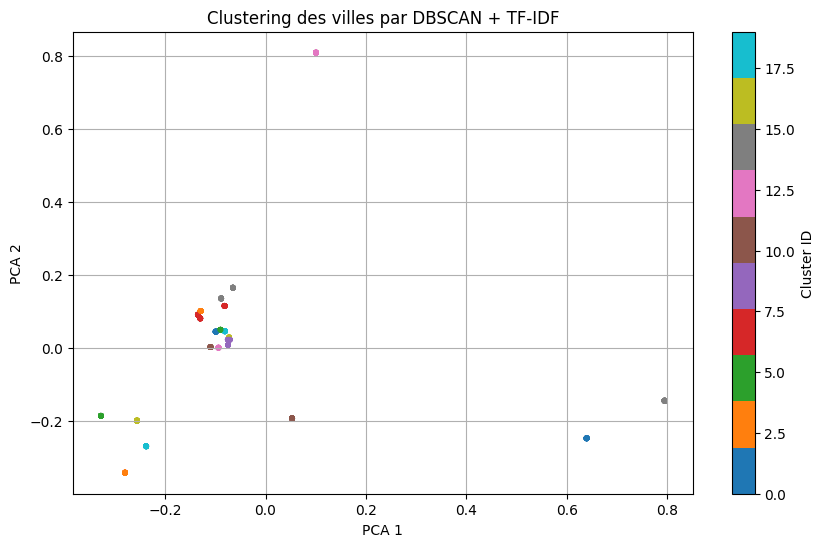

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd


fichier = "/Users/gouineaud/Desktop/4IF/INSA/PLD-SMART/city_only.csv"


def acronym(phrase):
    # Séparer les mots, prendre la première lettre de chaque, et mettre en majuscule
    return ''.join(word[0].upper() for word in phrase.split() if word)

# Lire le fichier
df = pd.read_csv(fichier)
print("Jeu de donnée passé en paramètres : ")
print(df)

# Récupérer uniquement les colonnes de type texte (objet = chaîne)
text_columns = df.select_dtypes(include="object").columns
#total_text_columns = len(text_columns)             #nombre de colonnes textuelles
#total_text_entries_columns = df[text_columns].size #nombre de données par colonnes
print("colonnes retenues (celles qui sont reconnues pour être du texte) : ", text_columns)

#init compte des valeurs à changer par synonymes dans la BD 
count_val_to_change_acronyms=0

#init dic d'acronym à rajouter à notre BD
dic_acronym={}

# Boucle sur chaque ligne des colonnes texte
for col in text_columns:
    #intialisation des set
    set_acronym = set()
    for val in df[col].dropna():  # ici on a enlever les valeurs nulles des colonnes car on ne traite pas ce cas dans ce critère
        if val not in set_acronym : 
            val_acronym=acronym(val)
            set_acronym.add(val_acronym)
            dic_acronym[val]=val_acronym
        else:
            count_val_to_change_acronyms+=1
    print(set_acronym)



df["Acronym"] = df["City"].map(dic_acronym)

# Vectorisation
vectorizer = TfidfVectorizer(analyzer='char_wb', ngram_range=(2, 4))
X = vectorizer.fit_transform(df['City'])

# Clustering
clustering = DBSCAN(eps=0.5, min_samples=3, metric='cosine')
df['Cluster'] = clustering.fit_predict(X)

# (Optionnel) évaluer les regroupements avec 'Acronym'
grouped = df.groupby(['Cluster', 'Acronym']).size().unstack(fill_value=0)

# Visualisation
pca = PCA(n_components=2)
coords = pca.fit_transform(X.toarray())

plt.figure(figsize=(10, 6))
plt.scatter(coords[:, 0], coords[:, 1], c=df['Cluster'], cmap='tab10', s=10)
plt.title("Clustering des villes par DBSCAN + TF-IDF")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="Cluster ID")
plt.grid(True)
plt.show()
